In [1]:
import jax
import jax.numpy as np
import numpy as onp
from jax import random, jit, vmap, grad, device_put
from jax.example_libraries import optimizers
import flax.linen as nn

import itertools
from functools import partial
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
# Modified MLP model for classification
def MLP(layers, activation=nn.relu):
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            b = np.zeros(d_out)
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, inputs):
        for W, b in params[:-1]:
            outputs = np.dot(inputs, W) + b
            inputs = activation(outputs)
        W, b = params[-1]
        outputs = np.dot(inputs, W) + b
        return nn.sigmoid(outputs)  # For binary classification output

    return init, apply

In [3]:

@optimizers.optimizer
def adam(step_size, b1=0.9, b2=0.999, eps=1e-8):
    step_size = optimizers.make_schedule(step_size)
    def init(x0):
        m0 = np.zeros_like(x0)
        v0 = np.zeros_like(x0)
        return x0, m0, v0
    def update(i, g, state):
        x, m, v = state
        m = (1 - b1) * g + b1 * m  # First  moment estimate.
        v = (1 - b2) * np.square(g) + b2 * v  # Second moment estimate.
        mhat = m / (1 - np.asarray(b1, m.dtype) ** (i + 1))  # Bias correction.
        vhat = v / (1 - np.asarray(b2, m.dtype) ** (i + 1))
        x = x - step_size(i) * mhat / (np.sqrt(vhat) + eps)
        return x, m, v
    def get_params(state):
        x, _, _ = state
        return x
    return init, update, get_params

In [4]:
@jit
def binary_cross_entropy_loss(logits, targets):
    return np.mean(-targets * np.log(logits + 1e-10) - (1 - targets) * np.log(1 - logits + 1e-10))

In [5]:
# Modified MLP class for binary classification
class MLPbin:
    def __init__(self, layers, rng_key):
        self.net_init, self.net_apply = MLP(layers, activation=nn.relu)
        params = self.net_init(rng_key)

        lr = optimizers.exponential_decay(1e-5, decay_steps=1000, decay_rate=0.9)
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        self.itercount = itertools.count()
        self.loss_log = []
        self.acc_log = []

    def loss(self, params, batch):
        inputs, targets = batch
        logits = self.net_apply(params, inputs)
        logits = 1 / (1 + np.exp(-logits))  # Sigmoid for binary probability
        return binary_cross_entropy_loss(logits, targets)

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, dataset, nIter=10000):
        data = iter(dataset)
        pbar = trange(nIter)
        for it in pbar:
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)  
            if it % 50 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0,))
    def predict(self, params, inputs):
        logits = self.net_apply(params, inputs)
        return 1 / (1 + np.exp(-logits))  # Sigmoid for probabilities

In [6]:
from torch.utils import data
class DataGenerator(data.Dataset):
    def __init__(self, X, Y, batch_size=128, rng_key=random.PRNGKey(123)):
        self.X = X
        self.Y = Y
        self.N = Y.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, X, Y):
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        inputs = X[idx,:]
        targets = Y[idx]
        return inputs, targets

    def __getitem__(self, index):
        self.key, subkey = random.split(self.key)
        inputs, targets = self.__data_generation(subkey, self.X, self.Y)
        return inputs, targets

In [7]:
dataset = onp.loadtxt("HIGGS.csv", delimiter=",")
X = dataset[:, 1:29]  # Features
Y = dataset[:, 0]     # Labels

# Select subsets
subset_X_1 = X[:1100]
subset_Y_1 = Y[:1100]
subset_X_2 = X[:110000]
subset_Y_2 = Y[:110000]

# Normalize
mu_X1, sigma_X1 = subset_X_1.mean(0), subset_X_1.std(0)
subset_X_1 = (subset_X_1 - mu_X1) / sigma_X1
mu_X2, sigma_X2 = subset_X_2.mean(0), subset_X_2.std(0)
subset_X_2 = (subset_X_2 - mu_X2) / sigma_X2

# Split data
train_X_1, test_X_1 = subset_X_1[:880], subset_X_1[880:]
train_Y_1, test_Y_1 = subset_Y_1[:880], subset_Y_1[880:]
train_X_2, test_X_2 = subset_X_2[:88000], subset_X_2[88000:]
train_Y_2, test_Y_2 = subset_Y_2[:88000], subset_Y_2[88000:]

# Initialize data
train_dataset_1 = DataGenerator(train_X_1, train_Y_1, batch_size=20)
train_dataset_2 = DataGenerator(train_X_2, train_Y_2, batch_size=20)

In [13]:
# Define the MLP model and train
model_1 = MLPbin(layers=[28, 64, 64, 1], rng_key=random.PRNGKey(0))
model_1.train(train_dataset_1, nIter=50000)

model_2 = MLPbin(layers=[28, 64, 64, 1], rng_key=random.PRNGKey(0))
model_2.train(train_dataset_2, nIter=50000)

100%|██████████| 50000/50000 [36:31<00:00, 22.81it/s, Loss=0.68212026] 


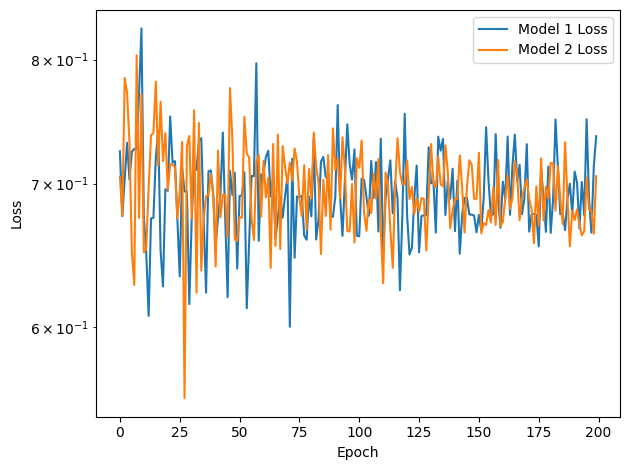

In [9]:
# Evaluation and plotting
plt.figure()
plt.plot(np.array(model_1.loss_log), label="Model 1 Loss")
plt.plot(np.array(model_2.loss_log), label="Model 2 Loss")
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:

def estimate_sensitivity(opt_params, model, X_test, noise_std=0.01, num_trials=500):
    sensitivities = []
    
    for _ in range(num_trials):
        # Add small Gaussian noise to X_test
        noise = noise_std * random.normal(random.PRNGKey(onp.random.randint(1e5)), X_test.shape)
        X_test_noisy = X_test + noise

        # Predict with the noisy input
        Y_pred_noisy = model.predict(opt_params, X_test_noisy)

        # Predict with the original input
        Y_pred_original = model.predict(opt_params, X_test)

        # Calculate the sensitivity as the variance of the change in predictions due to input noise
        sensitivity = np.mean((Y_pred_noisy - Y_pred_original)**2) / noise_std**2
        sensitivities.append(sensitivity)
        print(sensitivity, end='\t')
    
    # Return the average sensitivity across trials
    avg_sensitivity = np.mean(np.array(sensitivities))
    return avg_sensitivity


In [17]:
# Estimate sensitivities for both models over multiple trials
num_trials = 500

# Sensitivity for Model 1 (1,100 samples)
print("Sensitivity for Model 1:")
avg_sensitivity_model_1 = estimate_sensitivity(model_1.get_params(model_1.opt_state), model_1, subset_X_1, noise_std=0.1, num_trials=num_trials)
# Sensitivity for Model 2 (110,000 samples)
print()
print("Sensitivity for Model 2:")
avg_sensitivity_model_2 = estimate_sensitivity(model_2.get_params(model_2.opt_state), model_2, subset_X_2, noise_std=0.1, num_trials=num_trials)
print()
print(f"Average Sensitivity for Model 1: {avg_sensitivity_model_1:.8f}")
print()
print(f"Average Sensitivity for Model 2: {avg_sensitivity_model_2:.8f}")

Sensitivity for Model 1:
0.0005568638	0.000552319	0.00062267703	0.0006004879	0.00061008276	0.0005802439	0.0005346218	0.00056897465	0.00061203924	0.0005363601	0.0005369213	0.0005441791	0.00057174056	0.00057075516	0.00057729083	0.00053896627	0.0005262446	0.000516824	0.0005561273	0.0005692667	0.0005492831	0.0005786345	0.0005387723	0.00060610624	0.0005581969	0.0006046315	0.0005833746	0.0005651835	0.00052067975	0.0005601238	0.00054675806	0.0005919312	0.0005273791	0.0005475101	0.0005600924	0.0005388988	0.0005740311	0.00062393723	0.0005778336	0.0005680385	0.0005963581	0.0005406857	0.0005977365	0.000538299	0.00056094973	0.0005508562	0.00053597236	0.0005569143	0.00053951214	0.00056893454	0.00056359073	0.00057858386	0.00055745774	0.00057849486	0.000547061	0.00052941905	0.00057385315	0.0005773847	0.00054521114	0.00055899634	0.00056687143	0.0005886673	0.00056818436	0.0005785794	0.00060548435	0.0005832052	0.00054961676	0.00061463774	0.0005126548	0.0005672594	0.00060440076	0.00056123576	0.0006082390